In [1]:
import xarray as xr
import rioxarray as rxr
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
path_to_image = "../GEE/WaterExtractedMap_Mississippi10 (1).tif"

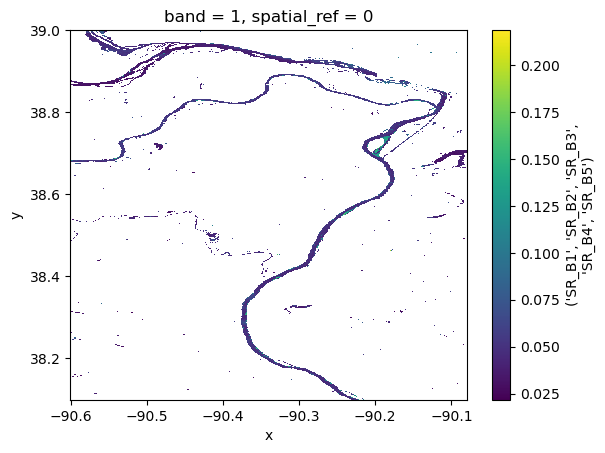

In [3]:
bands2d = rxr.open_rasterio(path_to_image)
bands2dWater =bands2d.where(bands2d!=0) #Extracted only water
bands2dWater.isel(band=0).plot()

In [37]:
def extract_gaugeRect(coordinate,bands2d,xRange=0.001,yRange=0.001):
    bboxXMin,bboxXMax = coordinate[0]-xRange,coordinate[0]+xRange
    bboxYMin,bboxYMax = coordinate[1]-yRange,coordinate[1]+yRange
    print(f"xrange={bboxXMin,bboxXMax},yrange={bboxYMin,bboxYMax}")
    rect = bands2d.sel(x=slice(bboxXMin,bboxXMax),y=slice(bboxYMax,bboxYMin))
    rect.isel(band=0).plot()
    return rect

xrange=(-90.186, -90.174),yrange=(38.550000000000004, 38.71)


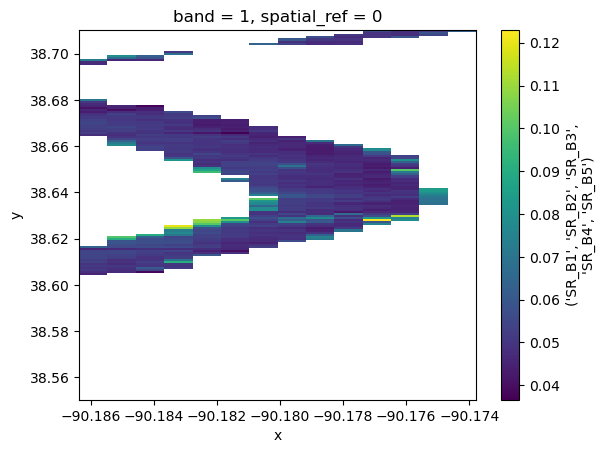

In [38]:
MS_lower = 	[-90.18, 38.63]# 07010000
extracted_rect = extract_gaugeRect(MS_lower,bands2d,xRange=0.006,yRange=0.08)

In [39]:
# step 1 岸に該当する点を抽出する
# ノイズは一旦無視できるとし、x,y両方向に探索をかけ、隣接
bandlen,ylen,xlen = extracted_rect.shape
print(bandlen,ylen,xlen)

surroundWaterPixel = np.zeros((ylen,xlen))
IsIntraWater = np.zeros((ylen,xlen))
for i in range(xlen):
    for j in range(ylen):
        if i == 0 or i==xlen-1 or j== 0 or j==ylen-1:
            surroundWaterPixel[j,i] =(extracted_rect[0,j,i]>0)
        else:
            #print(i,j)
            #隣接する水ピクセルの数を数える
            neighborPixel  = [(extracted_rect[0,j,i-1]>0) , (extracted_rect[0,j,i+1]>0), (extracted_rect[0,j-1,i]>0) ,(extracted_rect[0,j+1,i]>0)]
            pixelNum = sum(neighborPixel)
            #水ピクセルが1つか２つなら岸判定
            surroundWaterPixel[j,i] =(pixelNum==2) or (pixelNum==3)#(not pixelNum==4) and(not pixelNum==0)# 1<=pixelNum and pixelNum<=3
            IsIntraWater[j,i] = (pixelNum == 4)
print(surroundWaterPixel)
print(IsIntraWater)

5 178 14
[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [40]:
#川の流れが東西方向か、南北方向か判断する
#長方形の境界セルの水ピクセルの数で判断する

left = sum([(extracted_rect[0,i,0]>0) for i in range(ylen)])
right = sum([(extracted_rect[0,i,-1]>0) for i in range(ylen)])
upper = sum([(extracted_rect[0,0,j]>0) for j in range(xlen)])
bottom = sum([(extracted_rect[0,-1,j]>0) for j in range(xlen)])
print(f"left={left},right={right},upper={upper},bottom={bottom}")
horizontal = max(left,right)
vertical = max(upper,bottom)

left=<xarray.DataArray ()>
array(35)
Coordinates:
    band         int64 1
    x            float64 -90.19
    spatial_ref  int64 0,right=<xarray.DataArray ()>
array(1)
Coordinates:
    band         int64 1
    x            float64 -90.17
    spatial_ref  int64 0,upper=<xarray.DataArray ()>
array(4)
Coordinates:
    band         int64 1
    y            float64 38.71
    spatial_ref  int64 0,bottom=<xarray.DataArray ()>
array(0)
Coordinates:
    band         int64 1
    y            float64 38.55
    spatial_ref  int64 0


In [41]:
#スプライン補間のための、河川中心の座標（のリスト=np.zeros()）を取得する
if horizontal > vertical:
    #川は東西方向に流れる
    pass
else:
    #川は南北方向に流れる
    coord=[]
    for i in range(ylen):
        shoreIndex = [s for s, x in enumerate(surroundWaterPixel[i,:]) if x == 1]
        if not len(shoreIndex) ==0:
            #print(i,extracted_rect["x"][shoreIndex[0]].values,extracted_rect["y"][i].values,extracted_rect["x"][shoreIndex[-1]].values,extracted_rect["y"][i].values)
            #leftCoord  = [extracted_rect["x"][shoreIndex[0]],extracted_rect["y"][i]]
            #rightCoord = [extracted_rect["x"][shoreIndex[-1]],extracted_rect["y"][i]]
            lat=(extracted_rect["x"][shoreIndex[0]].values+extracted_rect["x"][shoreIndex[-1]].values)/2 #ノイズが入ると処理ができない
            lon=extracted_rect["y"][i].values
            coord.append(np.array([lat,lon]))

In [42]:
#　流線に垂直な直線と交わるラスタを見つける。
lineCollision = np.zeros((xlen,ylen))
vec_rivLine = []
for k in range(len(coord)-1):
    vec_rivLine = coord[k+1] - coord[k]

    #四角形と直線の交差判定　四角形をそれぞれのピクセルとし、それが流線に垂直な直線と交わるとき、そのピクセル群を同一グループにまとめる。グループ番号はkを割り当てる。
    for i in range(xlen-1):
        for j in range(ylen-1):
            p1 = np.array([extracted_rect["x"][i]-coord[k][0],extracted_rect["y"][j]-coord[k][1]])
            p2 = np.array([extracted_rect["x"][i]-coord[k][0],extracted_rect["y"][j+1]-coord[k][1]])
            p3 = np.array([extracted_rect["x"][i+1]-coord[k][0],extracted_rect["y"][j]-coord[k][1]])
            p4 = np.array([extracted_rect["x"][i+1]-coord[k][0],extracted_rect["y"][j+1]-coord[k][1]])

            dp1 = np.dot(vec_rivLine,p1)
            dp2 = np.dot(vec_rivLine,p2)
            dp3 = np.dot(vec_rivLine,p3)
            dp4 = np.dot(vec_rivLine,p4)

            if (dp1*dp2 <=0) or (dp2*dp3<=0) or (dp3*dp4<=0):#一つでも内積が異なればその辺と交差している。1-4は不要。
                lineCollision[i][j] = k


In [ ]:

for k in range(len(coord)-1):
    fig,ax = plt.subplots()
    WaterPixels = np.where((lineCollision == k) & (IsIntraWater.T == 1))
    for i in range(len(WaterPixels[0])):
        ax.plot(extracted_rect[:,WaterPixels[1][i],WaterPixels[0][i]])
    plt.show()
        

In [108]:
# 流線ベクトルを取得し、その法線（単位）ベクトルを求める。反時計回り90度
for i in range(len(lon)):
    for j in range(len(lat)):
        long = lon[i]
        lati = lat[j]
        abs = 1/np.sqrt(long**2+lati**2)
        verVec  = [abs * -lati ,abs * long]
print(verVec)

[0.9192503791767157, 0.39367339303471416]


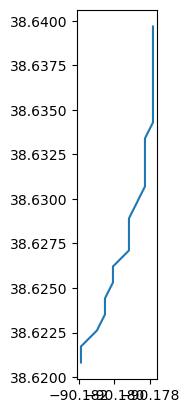

In [89]:
fig,ax = plt.subplots()
ax.plot(lat[:],lon[:])
ax.set_aspect("equal")
plt.show()